# Matematično ozadje

Analiza glavnih komponent (*angl.* Principal Component Analysis oz. PCA) je metoda za analizo podatkov. Navadno se uporablja za podatkovne nabore, ki imajo visoko dimenzijo. Z analizo glavnih komponent lahko dimenzijo nabora podatkov občutno zmanjšamo, kljub temu pa ohranimo večino informacij, ki jih vsebuje celoten nabor. To nam pogosto močno olajša analizo podatkov in nam omogoči, da iz njih lažje sklepamo kaj konkretnega.

V matematičnem jeziku je PCA preprosto linearni automorfizem nabora podatkov. Po transformaciji dobimo podatke zapisane v novi bazi, za katero velja, da imajo njeni bazni vektorji (ki jim pravimo glavne komponente) določeno urejenost. Prva glavna komponenta je vektor, v smeri katerega se ohrani največji delež variance, če nabor podatkov projiciramo nanj. Podobno velja za nadaljne glavne komponente.

Izkaže se, da so tako definirane glavne komponente ravno lastni vektorji kovariančne matrike nabora podatkov, urejene po velikostih njihovih lastnih vrednosti. Za računanje lastnih vektorjev obstaja veliko metod, ena izmed najbolj stabilnih je kar SVD razcep. Izračun glavnih komponent torej ni nič drugega kot SVD razcep kovariančne matrike nabora podatkov. 

# Reševanje

Analizirali bomo mutacije, ki se pojavljajo na genomih posameznikov, ki prihajajo iz različnih populacij. Z analizo PCA bomo poskusili identificirati glavne dejavnike za temi mutacijami. 

Najprej naložimo vse potrebne pythonove knjižnice, ki jih bomo potrebovali.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA


Preberemo nabor podatkov iz priložene datoteke ter mu dodamo ustrezno glavo, ki nam opiše kategorije posameznih parametrov. Nato izračunamo najpogostejše nukleobaze na posameznih mestih, saj bomo to potrebovali za analizo mutacij.

In [2]:
n = 10101
head = ['id', 'sex', 'population'] + list(range(n))
dataset = pd.read_csv("dataset.txt", delimiter=' ', header=None, names=head)
mode_nucleobase = dataset.mode(axis=0, numeric_only=False).iloc[:1, 3:].values.tolist()[0]

Sestavimo 995x10101 matriko, ki predstavlja mutacije na sekvencah genomov posameznikov iz nabora podatkov. Če se na j-tem mestu v sekvenci pojavi mutacija, je v matriki na tem mestu 1, drugače pa 0. To je dejanska numerična matrika podatkov, ki jo bomo analizirali.

In [3]:
matrix = np.array([
        [int(row[j] != mode) for j, mode in enumerate(mode_nucleobase)] for i, row in dataset.iterrows()]
)
        

Na dobljeni matriki mutacij zdaj izvedemo algoritem PCA ter shranimo prve 3 komponente.

In [4]:
pca = PCA(n_components=3)
pca.fit(matrix)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Naš prvi graf prikazuje projekcijo nabora podatkov na prostor, ki ga napenjata prvi dve glavni komponenti. Vsak posameznik je predstavljen s točko in ima določeno barvo glede na populacijo, kateri pripada.

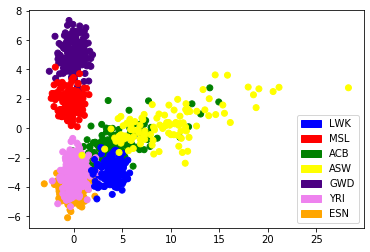

In [5]:
x = np.dot(matrix, pca.components_[0])
y = np.dot(matrix, pca.components_[1])
populations = list(set(dataset['population']))
colors_list = ['blue', 'red', 'green', 'yellow', 'indigo', 'violet', 'orange']
colors = {key: value for key, value in zip(populations, colors_list)}
scatter = plt.scatter(x, y, c=dataset['population'].map(colors))
handles=[mpatches.Patch(color=c, label=l) for c, l in zip(colors_list, populations)]
plt.legend(handles=handles)
plt.show()

Opazimo določene vzorce. Populaciji GWD in MSL sta si blizu in sta nekoliko ločeni od ostalih. Populaciji YRI in ESN se skoraj popolnoma prekrivata, populaciji ACB in ASW pa sta najbolj razpršeni. Vse te opazke imajo preprosto razlago, če pogledamo geografsko pripadnost danih populacij. Populacija GWD je iz območja Gambije, MSL pa iz Sierra Leone, torej sta geografsko nekoliko bolj zahodno od ostalih. Populaciji YRI in ESN sta obe iz območja Nigerije, zato se praktično prekrivata. Člani populacije ACB ljudje so z območja Barbadosa z afriškimi koreninami, člani populacije ASW pa ljudje z ameriškega jugovzhoda, prav tako z afriškimi koreninami. Zaradi mešanja z ostalimi narodnostmi v Ameriki ter na Karibih sta populaciji ACB in ASW torej razumljivo najbolj razpršeni.

Drugi graf prikazuje projekcijo na prostor, ki ga napenjata prva in tretja glavna komponenta. Vidimo lahko, da so podatki glede na y-os ločeni v dva približno enako velika sklopa. Najbolj verjetna razlaga je, da gre za sklopa moških in ženskih osebkov, torej y-os, oziroma tretja glavna komponenta, vsebuje podatek o spolu. To je pričakovano, saj vemo, da se moški in ženski genomi med seboj močno razlikujejo in so eden izmed glavnih povzročiteljev variance med genomi osebkov. 

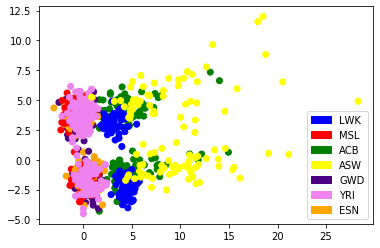

In [6]:
z = np.dot(matrix, pca.components_[2])
scatter = plt.scatter(x, z, c=dataset['population'].map(colors))
plt.legend(handles=handles)
plt.show()

Tretji graf prikazuje absolutno vrednost tretje glavne komponente na posameznem mestu v sekvenci. Vidimo, da so vrednosti skoraj povsod blizu 0. Bistveno večje vrednosti se pojavijo šele proti koncu, v približno zadnjih 10% sekvence. Glede na našo prejšnjo ugotovitev, da tretja glavna komponenta ujame raliko med spoloma, sklepamo, da se ta razlika izraža kot mutacija na zadnjem delu sekvence. Razlaga za to je preprosta: celotna sekvenca človeškega genoma je sestavljena iz 24 delov, ki se imenujejo kromosomi. Vemo, da se zadnja dva kromosoma razlikujeta glede na spol: ženski osebki imajo dva X kromosoma, moški pa kromosom X in Y. Če predpostavimo, da je bila naša sekvenca vzorčena v približno istem zaporedju, nam zadnjih del sekvence predstavja ravno varianco na tih dveh kromosomih, torej ni nič čudnega, da ima komponenta, ki ujame informacijo o spolu, neničelne vrednosti le na tem delu sekvence.

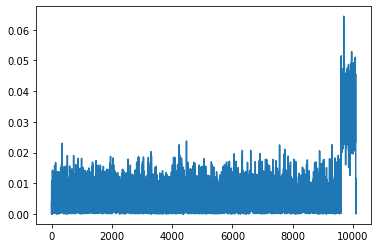

In [7]:
plt.plot(np.arange(n), list(map(abs, pca.components_[2])))
plt.show()